<h2 style="color: purple;">Employee Attrition Prediction App: End-to-End ML Project</h2>

- First, do some exploratory data analysis to figure out which variables have direct and clear impact on employee retention (i.e. whether they leave the company or continue to work)
- Plot bar charts showing impact of employee salaries on retention
- Plot bar charts showing corelation between department and employee retention
- Build logistic regression model using variables that were narrowed down in step 1
- Measure the accuracy of the model
- Build Gradio App for future predictions

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('hr_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h3 style="color:purple">Data exploration and visualization</h3>

In [3]:
left = df[df.left==1]
left.shape

(3571, 10)

In [4]:
retained = df[df.left==0]
retained.shape

(11428, 10)

**Average numbers for all columns**

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Group by 'left' and calculate the mean for numeric columns only
mean_values = df.groupby('left')[numeric_cols].mean()
mean_values

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
left,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.0,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,1.0,0.005321


From above table we can draw following conclusions,
<ol>
    <li>**Satisfaction Level**: Satisfaction level seems to be relatively low (0.44) in employees leaving the firm vs the retained ones (0.66)</li>
    <li>**Average Monthly Hours**: Average monthly hours are higher in employees leaving the firm (199 vs 207)</li>
    <li>**Promotion Last 5 Years**: Employees who are given promotion are likely to be retained at firm </li>
</ol>

**Impact of salary on employee retention**

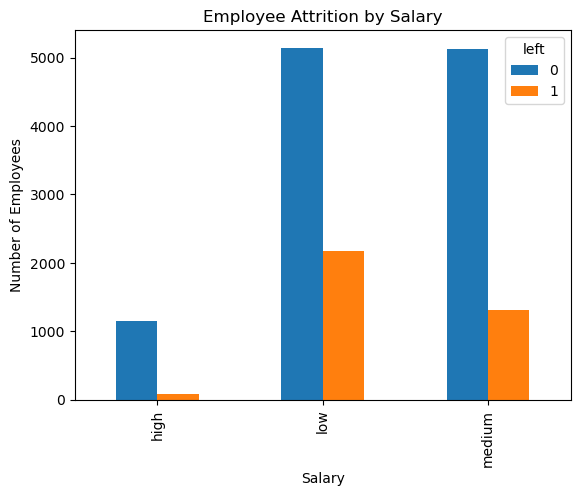

In [23]:
pd.crosstab(df.salary, df.left).plot(kind='bar')

# Show the plot
plt.xlabel('Salary')
plt.ylabel('Number of Employees')
plt.title('Employee Attrition by Salary')
plt.show()

Above bar chart shows employees with high salaries are likely to not leave the company

**Department wise employee retention rate**

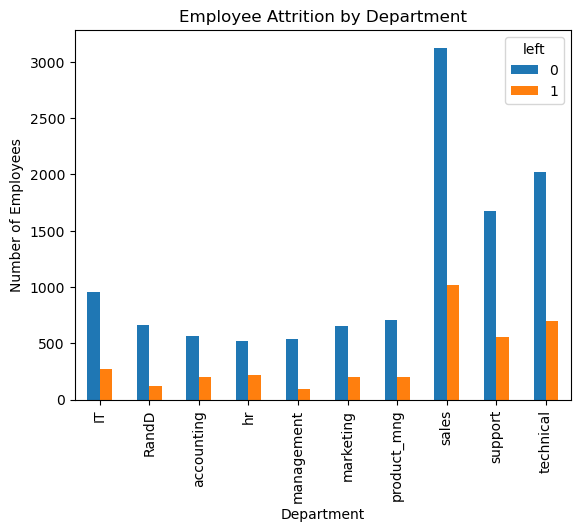

In [7]:
pd.crosstab(df.Department, df.left).plot(kind='bar')

# Show the plot
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.title('Employee Attrition by Department')
plt.show()

From above chart there seem to be some impact of department on employee retention but it is not major hence we will ignore department in our analysis

<h3 style="color:purple">From the data analysis so far we can conclude that we will use following variables as independant variables in our model</h3>
<ol>
    <li>**Satisfaction Level**</li>
    <li>**Average Monthly Hours**</li>
    <li>**Promotion Last 5 Years**</li>
    <li>**Salary**</li>
</ol>

In [8]:
subdf = df[['satisfaction_level','average_montly_hours','promotion_last_5years','salary']]
subdf.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary
0,0.38,157,0,low
1,0.80,262,0,medium
2,0.11,272,0,medium
3,0.72,223,0,low
4,0.37,159,0,low


**Tackle salary dummy variable**
Salary has all text data. It needs to be converted to numbers and we will use dummy variable for that

In [9]:
# Prepare the data
subdf = subdf.copy()

# Label encoding
le_salary = LabelEncoder()
subdf['salary_encoded'] = le_salary.fit_transform(subdf['salary'])

<h3 style="color:purple">Model Training and Evaluation</h3>

In [10]:
X = subdf[['satisfaction_level', 'average_montly_hours', 'promotion_last_5years', 'salary_encoded']]
y = df['left'].astype(int)

# Split the data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and classification report for Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
rf_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2294
           1       0.88      0.87      0.87       706

    accuracy                           0.94      3000
   macro avg       0.92      0.91      0.92      3000
weighted avg       0.94      0.94      0.94      3000



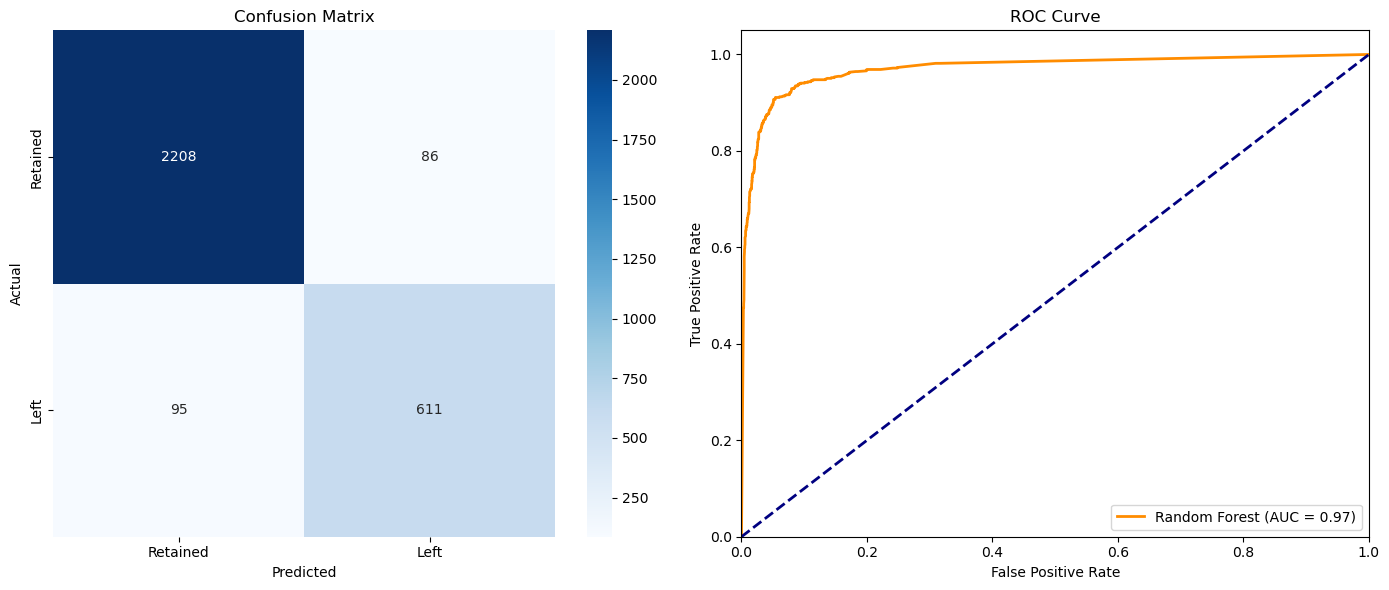

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Get ROC curve data
y_pred_rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_prob)
roc_auc = auc(fpr, tpr)

# Create side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Confusion Matrix Plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Retained', 'Left'], yticklabels=['Retained', 'Left'], ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

# ROC Curve Plot
ax[1].plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

# Adjust layout and display
plt.tight_layout()
plt.show()


<h3 style="color:purple">Build Gradio interactive interface for predicting employee attrition</h3>

In [13]:
def get_insight(satisfaction_level, average_montly_hours, promotion_last_5years, salary, probability):
    insights = []
    
    # Primary insight based on probability
    if probability > 0.75:
        insights.append(f"High risk of attrition (Probability: {probability:.2f}). Immediate action is required.")
    elif probability > 0.5:
        insights.append(f"Moderate risk of attrition (Probability: {probability:.2f}). Close attention and intervention are needed.")
    elif probability > 0.25:
        insights.append(f"Low risk of attrition (Probability: {probability:.2f}), but monitoring is advised.")
    else:
        insights.append(f"Very low risk of attrition (Probability: {probability:.2f}). The employee is likely to stay.")

    # Additional context based on other factors
    if satisfaction_level < 0.4 and probability > 0.5:
        insights.append("Low satisfaction level is a key factor contributing to the attrition risk.")
    
    if average_montly_hours > 300 and probability > 0.5:
        insights.append("High number of working hours may be contributing to burnout and increased attrition risk.")
    elif average_montly_hours < 150 and probability > 0.5:
        insights.append("Low number of working hours might indicate disengagement, contributing to attrition risk.")
    
    if promotion_last_5years == 0 and probability > 0.5:
        insights.append("Lack of recent promotion could be a factor in the attrition risk.")
    
    if salary == 'low' and probability > 0.5:
        insights.append("Low salary is likely contributing to the attrition risk.")

    # Positive factors (if risk is low)
    if probability <= 0.5:
        if satisfaction_level > 0.6:
            insights.append("Good satisfaction level is a positive factor for retention.")
        if 200 <= average_montly_hours <= 250:
            insights.append("Balanced working hours contribute to employee stability.")
        if promotion_last_5years == 1:
            insights.append("Recent promotion is a positive factor for retention.")
        if salary in ['medium', 'high']:
            insights.append(f"{salary.capitalize()} salary level supports employee retention.")

    return " ".join(insights)

In [14]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

def predict_attrition(satisfaction_level, average_montly_hours, promotion_last_5years, salary):
    try:
        if salary is None:
            raise ValueError("Salary cannot be None. Please select a salary level.")
        
        if salary not in ['low', 'medium', 'high']:
            raise ValueError(f"Invalid salary value: {salary}. Expected 'low', 'medium', or 'high'.")
        
        # Encode salary
        salary_encoded = le_salary.transform([salary])[0]
        
        # Prepare input data
        input_data = np.array([[
            float(satisfaction_level), 
            float(average_montly_hours), 
            int(promotion_last_5years), 
            salary_encoded
        ]])
        
        # Scale input data
        input_scaled = scaler.transform(input_data)
        
        # Make prediction
        prediction = rf_model.predict(input_scaled)[0]
        probability = rf_model.predict_proba(input_scaled)[0][1]
        
        # Get insight
        insight = get_insight(satisfaction_level, average_montly_hours, int(promotion_last_5years), salary, probability)
        
        # Determine result and image
        if prediction == 1:
            result = "Leave"
            image = "left.png"
        else:
            result = "Stay"
            image = "retained.png"
        
        return result, f"{probability*100:.1f}%", insight, image
    
    except Exception as e:
        error_message = f"Error: {str(e)}"
        print(error_message)  # Print to console for debugging
        return error_message, "Unable to generate insights due to an error.", "error.png"

In [15]:
def create_dashboard():
    with gr.Blocks(theme=gr.themes.Ocean()) as dashboard:
        gr.Markdown("# Employee Attrition Predictor Dashboard")
        gr.Markdown("Predict whether an employee is likely to leave based on various factors.")
        
        with gr.Row():
            with gr.Column(scale=2):
                satisfaction = gr.Slider(0, 1, value=0.5, step=0.01, label="Satisfaction Level")
                hours = gr.Slider(0, 400, value=200, step=1, label="Average Monthly Hours")
                promotion = gr.Radio(["0", "1"], value="0", label="Promotion in Last 5 Years")
                salary = gr.Dropdown(["Select salary level", "low", "medium", "high"], value="Select salary level", label="Salary")
                predict_btn = gr.Button("Predict Attrition", variant="primary")
            
            with gr.Column(scale=3):
                with gr.Row():
                    prediction = gr.Textbox(label="Prediction")
                    probability = gr.Textbox(label="Probability of Leaving")
                with gr.Row():
                    image = gr.Image(type="filepath", label="Status", height=208, width=200)
                    insight = gr.Textbox(label="Insights", lines=6)
        
        predict_btn.click(
            predict_attrition,
            inputs=[satisfaction, hours, promotion, salary],
            outputs=[prediction, probability, insight, image]
        )

    return dashboard

iface = create_dashboard()
iface.launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
